In [8]:
# ===================================================================
# CÉLULA 0: IMPORTAÇÕES E DEFINIÇÕES DE FUNÇÕES
# ===================================================================

# --- Bibliotecas Padrão ---
import os
import time
import warnings
from datetime import datetime

# --- Bibliotecas de Terceiros (Dados e ML) ---
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# --- Bibliotecas CapyMOA ---
try:
    from capymoa.stream import NumpyStream
    # O algoritmo para detecção de anomalia
    from capymoa.anomaly import HalfSpaceTrees 
    from capymoa.evaluation import ClassificationEvaluator
except ImportError:
    print("Aviso: Biblioteca 'capymoa' não encontrada. 'pip install capymoa'")
    NumpyStream = None
    HalfSpaceTrees = None

# --- Bibliotecas de Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuração de Avisos ---
warnings.filterwarnings('ignore')


In [9]:

# -----------------------------------------------------------------
# DEFINIÇÕES DE FUNÇÕES
# -----------------------------------------------------------------

def processar_e_salvar_stream_com_labels(
    file_path, 
    output_csv_path, 
    label_encoder, 
    target_col, 
    cols_nao_features,
    filter_labels=None
):
    """
    Processa um CSV bruto (CIC-IDS2017):
    1. Lida com a coluna duplicada 'Fwd Header Length'.
    2. Filtra pelos rótulos desejados (se 'filter_labels' for fornecido).
    3. Codifica rótulos (usando o encoder global).
    4. Limpa features (remove não-numéricas, imputa nulos).
    5. Salva o CSV (Features + Label) pronto para o stream.
    
    ATENÇÃO: Esta versão não ordena por Timestamp, pois ele não existe na lista.
    """
    print(f"\n--- Processando: {file_path} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado em {file_path}")
        return None
    
    # 1. Limpa nomes de colunas (remove espaços extras)
    df.columns = df.columns.str.strip()
    target_col = target_col.strip()
    
    # Lida com a coluna duplicada 'Fwd Header Length'
    # O Pandas renomeia a segunda para 'Fwd Header Length.1'
    if 'Fwd Header Length.1' in df.columns:
        print("Coluna duplicada 'Fwd Header Length.1' encontrada.")
    
    # 2. Filtra pelos rótulos desejados
    if filter_labels:
        print(f"Filtrando por rótulos: {filter_labels}")
        df = df[df[target_col].isin(filter_labels)]
        if df.empty:
            print(f"Aviso: Nenhum dado encontrado para os rótulos {filter_labels}.")
            return None

    # 3. Codifica Rótulos (usando o encoder global)
    try:
        df[target_col] = label_encoder.transform(df[target_col].astype(str))
    except ValueError as e:
        print(f"ERRO: Rótulos no arquivo não foram encontrados no encoder global: {e}")
        return None

    # 4. Limpa Features
    cols_nao_features_clean = [col.strip() for col in cols_nao_features]
    
    # Adiciona a coluna duplicada à lista de remoção, se existir
    if 'Fwd Header Length.1' in df.columns:
        if 'Fwd Header Length.1' not in cols_nao_features_clean:
            cols_nao_features_clean.append('Fwd Header Length.1')
            
    cols_existentes_para_remover = [col for col in cols_nao_features_clean if col in df.columns]
    
    y_data_series = df[target_col].copy()
    X_data_df = df.drop(columns=cols_existentes_para_remover + [target_col], errors='ignore')

    # 5. Garante que X é 100% Numérico
    X_data_df_numeric = X_data_df.select_dtypes(include=np.number)
    
    # 6. Trata Infinitos e Nulos (Imputação)
    X_data_df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    nan_counts = X_data_df_numeric.isnull().sum().sum()
    if nan_counts > 0:
        print(f"Imputando {nan_counts} valores nulos/infinitos com a mediana...")
        # Fallback .fillna(0) caso uma coluna inteira seja NaN
        X_data_df_cleaned = X_data_df_numeric.fillna(X_data_df_numeric.median()).fillna(0)
    else:
        print("Nenhum valor nulo/infinito encontrado.")
        X_data_df_cleaned = X_data_df_numeric
        
    # 7. Salva o CSV
    df_stream_pronto = pd.concat([X_data_df_cleaned, y_data_series], axis=1)
    
    try:
        df_stream_pronto.to_csv(output_csv_path, index=False)
        print(f"Stream salvo com sucesso em '{output_csv_path}' (Shape: {df_stream_pronto.shape})")
        return df_stream_pronto
    except Exception as e:
        print(f"ERRO: Falha ao salvar CSV. Erro: {e}")
        return None

def carregar_stream_do_csv(csv_path, target_col_name, stream_name_prefix="loaded_stream"):
    """
    Carrega um CSV PRONTO e o converte diretamente em um NumpyStream.
    Assume que a última coluna do CSV é o rótulo (target).
    """
    print(f"\n--- Carregando Stream do CSV: {csv_path} ---")
    try:
        df_reload = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"    - ERRO: Arquivo CSV não encontrado em '{csv_path}'")
        return None
    
    target_col_name_clean = target_col_name.strip()
    
    # Verifica se a última coluna é o rótulo
    if df_reload.columns[-1] != target_col_name_clean:
        print(f"    - ERRO: A última coluna do CSV ('{df_reload.columns[-1]}') não é o rótulo esperado ('{target_col_name_clean}').")
        return None

    # Pega todas as colunas, exceto a última
    X_data = df_reload.iloc[:, :-1].values.astype(np.float64)
    # Pega apenas a última coluna
    y_data = df_reload.iloc[:, -1].values
    
    print(f"  [OK] Dados preparados: X_shape={X_data.shape}, y_shape={y_data.shape}.")

    if NumpyStream:
        stream = NumpyStream(
            X_data, y_data,
            target_name=target_col_name_clean,
            dataset_name=stream_name_prefix
        )
        stream.restart() 
        return stream
    return None

print("Célula 0 (Definições) concluída. Funções carregadas.")

Célula 0 (Definições) concluída. Funções carregadas.


In [10]:

print("--- Iniciando Célula 1: Processamento de Dados (Unsupervised) ---")

# -----------------------------------------------------------------
# 0. CONFIGURAÇÃO (Ajuste estes caminhos)
# -----------------------------------------------------------------
# --- Arquivos de Entrada (CIC-IDS2017) ---
# Altere estes caminhos para os seus arquivos
FILE_TRAIN_BENIGN = "datasets/CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
FILE_TEST_ATTACK = "datasets/CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"

# --- Arquivos de Saída (Artefatos) ---
ENCODER_PATH = "ids2017_global_label_encoder.joblib"
PATH_CSV_TREINO = "ids2017_stream_pronto_TREINO_Benign.csv"
PATH_CSV_TESTE = "ids2017_stream_pronto_TESTE_Attack.csv"

# --- Definições das Colunas (CORRIGIDAS) ---
TARGET_COL = "Label" # Sem espaço, como na lista fornecida
# TIME_COL não é mais usado

# Colunas a serem removidas (não-features)
# Com base na lista de 79 colunas, a maioria já é numérica.
# 'Destination Port' é removido por ser categórico (ruim para HalfSpaceTrees).
# O .1 é a duplicata que o pandas cria.
COLS_NAO_FEATURES = [
    'Destination Port',
    'Fwd Header Length.1' # A duplicata
]
# -----------------------------------------------------------------

--- Iniciando Célula 1: Processamento de Dados (Unsupervised) ---


In [11]:

try:
    # 1. Criar LabelEncoder Global (para *avaliação* posterior)
    print("Criando LabelEncoder Global (lendo ambos os arquivos)...")
    df_benign_raw = pd.read_csv(FILE_TRAIN_BENIGN)
    df_attack_raw = pd.read_csv(FILE_TEST_ATTACK)
    
    # Limpa os nomes das colunas de ambos
    df_benign_raw.columns = df_benign_raw.columns.str.strip()
    df_attack_raw.columns = df_attack_raw.columns.str.strip()
    
    all_labels = pd.concat([
        df_benign_raw[TARGET_COL], 
        df_attack_raw[TARGET_COL]
    ]).astype(str).unique()
    
    le_global = LabelEncoder()
    le_global.fit(all_labels)
    joblib.dump(le_global, ENCODER_PATH)
    print(f"LabelEncoder Global salvo em: {ENCODER_PATH}")
    mapping = dict(zip(le_global.classes_, le_global.transform(le_global.classes_)))
    print(f"Mapeamento Global: {mapping}")
    
    # 2. Processar e Salvar Stream de TREINO (Apenas BENIGN)
    processar_e_salvar_stream_com_labels(
        file_path=FILE_TRAIN_BENIGN,
        output_csv_path=PATH_CSV_TREINO,
        label_encoder=le_global,
        target_col=TARGET_COL,
        cols_nao_features=COLS_NAO_FEATURES,
        filter_labels=['BENIGN'] # Filtra SÓ benignos para o treino
    )

    # 3. Processar e Salvar Stream de TESTE (Quinta-feira - BENIGN + Ataques)
    processar_e_salvar_stream_com_labels(
        file_path=FILE_TEST_ATTACK,
        output_csv_path=PATH_CSV_TESTE,
        label_encoder=le_global,
        target_col=TARGET_COL,
        cols_nao_features=COLS_NAO_FEATURES,
        filter_labels=None # Pega TODOS os rótulos deste arquivo
    )
    
    print("\n\nCÉLULA 1 CONCLUÍDA. Artefatos salvos.")

except FileNotFoundError as e:
    print(f"ERRO CRÍTICO: Arquivo RAW não encontrado. Verifique os caminhos. {e}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA 1: {e}")

Criando LabelEncoder Global (lendo ambos os arquivos)...
LabelEncoder Global salvo em: ids2017_global_label_encoder.joblib
Mapeamento Global: {'BENIGN': np.int64(0), 'DoS GoldenEye': np.int64(1), 'DoS Hulk': np.int64(2), 'DoS Slowhttptest': np.int64(3), 'DoS slowloris': np.int64(4), 'Heartbleed': np.int64(5)}

--- Processando: datasets/CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv ---
Coluna duplicada 'Fwd Header Length.1' encontrada.
Filtrando por rótulos: ['BENIGN']
Imputando 874 valores nulos/infinitos com a mediana...
Stream salvo com sucesso em 'ids2017_stream_pronto_TREINO_Benign.csv' (Shape: (529918, 77))

--- Processando: datasets/CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv ---
Coluna duplicada 'Fwd Header Length.1' encontrada.
Imputando 2594 valores nulos/infinitos com a mediana...
Stream salvo com sucesso em 'ids2017_stream_pronto_TESTE_Attack.csv' (Shape: (692703, 77))


CÉLULA 1 CONCLUÍDA. Artefatos salvos.



--- Iniciando Célula 2: Treinamento (HalfSpaceTrees) e Teste ---
Carregando encoder de: ids2017_global_label_encoder.joblib
Índice 'BENIGN' é: 0
Carregando stream de treino de: ids2017_stream_pronto_TREINO_Benign.csv

--- Carregando Stream do CSV: ids2017_stream_pronto_TREINO_Benign.csv ---
  [OK] Dados preparados: X_shape=(529918, 76), y_shape=(529918,).
Carregando stream de teste de: ids2017_stream_pronto_TESTE_Attack.csv

--- Carregando Stream do CSV: ids2017_stream_pronto_TESTE_Attack.csv ---
  [OK] Dados preparados: X_shape=(692703, 76), y_shape=(692703,).

Inicializando HalfSpaceTrees...
Iniciando Treinamento (dados benignos)...
Treinamento concluído em 29.72s

Iniciando Calibração (encontrando limiar de anomalia)...
Limiar de Anomalia definido em: 0.9999 (99º percentil)

Iniciando Teste (Auto-rotulagem de dados com ataques)...
Teste concluído em 35.64s

--- Análise Detalhada (Detecção de Anomalia) ---

Relatório de Classificação (Normal vs. Anomalia):
               precision  

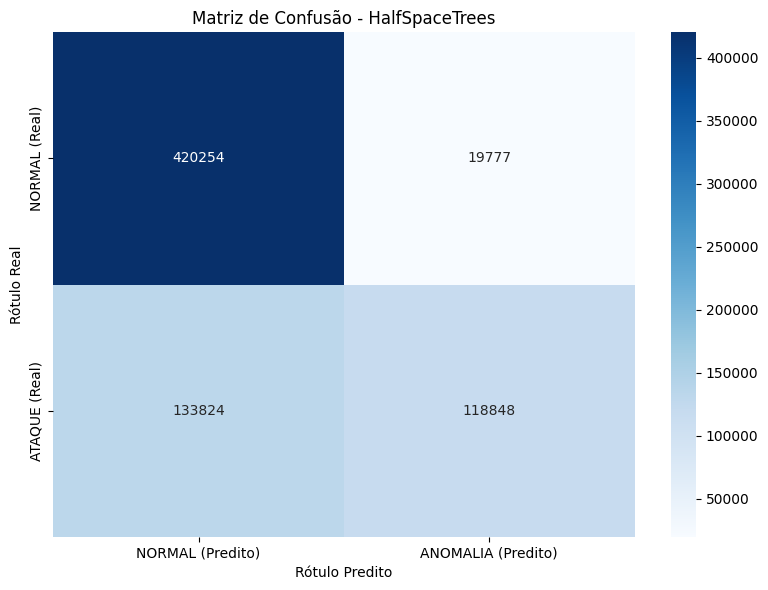


CÉLULA 2 CONCLUÍDA.


In [14]:
# ===================================================================
# CÉLULA 2: TREINAMENTO (Unsupervised) E TESTE (CORRIGIDA)
# ===================================================================

print("\n--- Iniciando Célula 2: Treinamento (HalfSpaceTrees) e Teste ---")
try:
    # -----------------------------------------------------------------
    # 1. CARREGAR ARTEFATOS
    # -----------------------------------------------------------------
    print(f"Carregando encoder de: {ENCODER_PATH}")
    le_global = joblib.load(ENCODER_PATH)
    
    try:
        BENIGN_INDEX = int(le_global.transform(['BENIGN'])[0])
        print(f"Índice 'BENIGN' é: {BENIGN_INDEX}")
    except ValueError:
        print("ERRO: 'BENIGN' não foi encontrado no LabelEncoder. Verifique seu dataset.")
        raise

    print(f"Carregando stream de treino de: {PATH_CSV_TREINO}")
    stream_treino_benign = carregar_stream_do_csv(
        PATH_CSV_TREINO, TARGET_COL, "TREINO_BENIGN"
    )
    
    print(f"Carregando stream de teste de: {PATH_CSV_TESTE}")
    stream_teste_attack = carregar_stream_do_csv(
        PATH_CSV_TESTE, TARGET_COL, "TESTE_ATTACK"
    )

    if stream_treino_benign is not None and stream_teste_attack is not None:
        
        # -----------------------------------------------------------------
        # 2. FASE 1: TREINAMENTO (Apenas com dados Benignos)
        # -----------------------------------------------------------------
        print("\nInicializando HalfSpaceTrees...")
        model = HalfSpaceTrees(schema=stream_treino_benign.schema)

        print("Iniciando Treinamento (dados benignos)...")
        start_train_time = time.time()
        
        stream_treino_benign.restart()
        while stream_treino_benign.has_more_instances():
            instance = stream_treino_benign.next_instance()
            
            # --- CORREÇÃO AQUI ---
            # O método para detectores de anomalia é '.train()'
            model.train(instance) 
            # --- FIM DA CORREÇÃO ---
            
        end_train_time = time.time()
        print(f"Treinamento concluído em {end_train_time - start_train_time:.2f}s")
        
        # -----------------------------------------------------------------
        # 3. FASE 2: CALIBRAÇÃO (Definir o limiar de "Anomalia")
        # -----------------------------------------------------------------
        print("\nIniciando Calibração (encontrando limiar de anomalia)...")
        benign_scores = []
        
        stream_treino_benign.restart()
        while stream_treino_benign.has_more_instances():
            instance = stream_treino_benign.next_instance()
            # O método de scoring é '.score_instance()' (conforme doc) ou '.score_one()' (API mais nova)
            # Vamos tentar a API documentada:
            try:
                score = model.score_instance(instance) # Da documentação
            except AttributeError:
                score = model.score_one(instance) # Fallback
                
            benign_scores.append(score)
            
        ANOMALY_THRESHOLD = np.quantile(benign_scores, 0.99)
        print(f"Limiar de Anomalia definido em: {ANOMALY_THRESHOLD:.4f} (99º percentil)")

        # -----------------------------------------------------------------
        # 4. FASE 3: TESTE (Auto-rotulagem e Avaliação)
        # -----------------------------------------------------------------
        print("\nIniciando Teste (Auto-rotulagem de dados com ataques)...")
        y_true_list = [] # O rótulo real (0=Benign, 1=Ataque)
        y_pred_list = [] # Nossa predição (0=Normal, 1=Anomalia)
        
        start_test_time = time.time()
        stream_teste_attack.restart()
        
        while stream_teste_attack.has_more_instances():
            instance = stream_teste_attack.next_instance()
            
            try:
                score = model.score_instance(instance)
            except AttributeError:
                score = model.score_one(instance)
                
            predicted_label = 1 if score > ANOMALY_THRESHOLD else 0 # 1=Anomalia, 0=Normal
            true_label = 0 if instance.y_index == BENIGN_INDEX else 1 # 0=Benign, 1=Qualquer Ataque
            
            y_pred_list.append(predicted_label)
            y_true_list.append(true_label)
            
            # 3. Adaptação Contínua
            if predicted_label == 0: 
                 
                 # --- CORREÇÃO AQUI ---
                 model.train(instance)
                 # --- FIM DA CORREÇÃO ---

        end_test_time = time.time()
        print(f"Teste concluído em {end_test_time - start_test_time:.2f}s")

        # -----------------------------------------------------------------
        # 5. FASE 4: MÉTRICAS (Detecção de Anomalia)
        # -----------------------------------------------------------------
        print("\n--- Análise Detalhada (Detecção de Anomalia) ---")
        
        labels_indices = [0, 1]
        labels_names_pred = ["NORMAL (Predito)", "ANOMALIA (Predito)"]
        labels_names_true = ["NORMAL (Real)", "ATAQUE (Real)"]

        # Relatório de Classificação
        print("\nRelatório de Classificação (Normal vs. Anomalia):")
        report = classification_report(
            y_true_list, y_pred_list, 
            labels=labels_indices, 
            target_names=labels_names_true,
            zero_division=0, digits=4
        )
        print(report)

        # Heatmap da Matriz de Confusão
        print("\nGerando Heatmap da Matriz de Confusão...")
        cm = confusion_matrix(y_true_list, y_pred_list, labels=labels_indices)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_names_pred, 
            yticklabels=labels_names_true
        )
        plt.title(f'Matriz de Confusão - {model.__class__.__name__}')
        plt.xlabel('Rótulo Predito')
        plt.ylabel('Rótulo Real')
        plt.tight_layout()
        plt.show() # Exibe o gráfico

    else:
        print("ERRO: Falha ao carregar um ou mais artefatos (encoder ou streams).")

except NameError as e:
    print(f"ERRO: Funções/Variáveis não definidas. Execute a Célula 0 primeiro. {e}")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado. Verifique os caminhos em PATH_*. {e}")
except Exception as e:
    print(f"ERRO INESPERADO NA CÉLULA 2: {e}")

print("\nCÉLULA 2 CONCLUÍDA.")